In [2]:
import itertools
import os
import random
import re
from glob import glob
import matplotlib.pyplot as plt
import h5py
import numpy as np
import torch
from scipy import ndimage
from scipy.ndimage.interpolation import zoom
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
import pandas as pd
import argparse
import importlib
from torch.nn.modules.loss import CrossEntropyLoss
import torch.backends.cudnn as cudnn
from torch.nn.functional import one_hot
from time import strftime
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
from tqdm.auto import tqdm
import torch.utils.data as data
from torch.distributions import Normal, Independent
from PIL import Image

/tmp/ipykernel_378/2906129279.py:12: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


In [ ]:
import os
import re
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt

class BUSIDataset(Dataset):
    def __init__(self, base_dir=None, split='train', transform=None, fold="fold1", sup_type="label"):
        self._base_dir = base_dir
        self.sample_list = []
        self.split = split
        self.sup_type = sup_type
        self.transform = transform
        train_ids, eval_ids = self._get_fold_ids(fold)
        # print(len(train_ids), len(eval_ids))
        all_samples = [f for f in os.listdir(self._base_dir) if f.endswith('.png')]
        # print(train_ids[0])
        if self.split == 'train':
            for ids in train_ids:
                new_data_list = list(filter(lambda x: x.startswith(ids), all_samples))
                self.sample_list.extend(new_data_list)
        
        elif self.split in ['val', 'test']:
            for ids in eval_ids:
                new_data_list = list(filter(lambda x: x.startswith(ids), all_samples))
                self.sample_list.extend(new_data_list)

        print("total {} samples".format(len(self.sample_list)))

    def _get_fold_ids(self, fold):
        root_fold_path = "/kaggle/input/scribble-busi/"
        train_fold_path = root_fold_path + str(fold) + "_train.txt"
        eval_fold_path = root_fold_path + str(fold) + "_test.txt"
        if fold == "TEST":
            TEST_path = "/kaggle/input/scribble-busi/TEST.txt"
            with open(TEST_path, 'r') as f:
                eval_ids = [str(line.strip()) for line in f.readlines()]
            return [], eval_ids
        
        with open(train_fold_path, 'r') as f:
            train_ids = [str(line.strip()) for line in f.readlines()]
    
        with open(eval_fold_path, 'r') as f:
            eval_ids = [str(line.strip()) for line in f.readlines()]
        return train_ids, eval_ids

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        case = self.sample_list[idx]
        case_name = os.path.splitext(case)[0]

        image_path = os.path.join(self._base_dir, f"{case_name}.png")
        label_path = os.path.join(self._base_dir, f"{case_name}_label.npy")
        edge_path = os.path.join(self._base_dir, f"{case_name}_edge.npy")
        scribble_path = os.path.join(self._base_dir, f"{case_name}_scribble.npy")
    
        image = np.array(Image.open(image_path))[:,:,0]
        image = image.astype(np.float32)
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        label = np.load(label_path, allow_pickle=True)
        edge = np.load(edge_path, allow_pickle=True)
        scribble = np.load(scribble_path, allow_pickle=True)
        original_scribble = scribble.copy()
        scribble[original_scribble == 2] = 0
        scribble[original_scribble == 0] = 2
        if self.split == 'train':
            sample = {'image': image, 'gt': label, 'edge_mask': edge, 'label': scribble, 'case': case}
        
            if self.transform is not None:
                sample = self.transform(sample)
        else:
            sample = {'image': image, 'label': label.astype(np.int8)}
        sample["idx"] = idx
        return sample

In [ ]:
def random_rot_flip(image, label, edge_mask):
    k = np.random.randint(0, 4)
    axis = np.random.randint(0, 2)
    image = np.rot90(image, k)
    label = np.rot90(label, k)
    image = np.flip(image, axis=axis).copy()
    label = np.flip(label, axis=axis).copy()
    if edge_mask is not None:
        edge_mask = np.rot90(edge_mask, k)
        edge_mask = np.flip(edge_mask, axis=axis).copy()

    return image, label, edge_mask


def random_rotate(image, label, edge_mask, cval):
    angle = np.random.randint(-20, 20)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0,
                           reshape=False, mode="constant", cval=cval)
    if edge_mask is not None:
        edge_mask = ndimage.rotate(edge_mask, angle, order=0,reshape=False)  

    return image, label, edge_mask


class RandomGenerator(object):
    def __init__(self, output_size, is_edge_mask=False):
        self.output_size = output_size
        self.is_edge_mask = is_edge_mask

    def __call__(self, sample):
        if self.is_edge_mask:
            image, label, edge_mask = sample['image'], sample['label'], sample['edge_mask']
        
        else:
            image, label = sample['image'], sample['label']
            edge_mask = None
        if random.random() > 0.5:
            image, label, edge_mask = random_rot_flip(image, label, edge_mask)
        elif random.random() > 0.5:
            if 2 in np.unique(label):
                image, label, edge_mask = random_rotate(image, label, edge_mask,cval=2)
            else:
                image, label, edge_mask = random_rotate(image, label, edge_mask,cval=0)
        x, y = image.shape
        image = zoom(
            image, (self.output_size[0] / x, self.output_size[1] / y), order=0)
        label = zoom(
            label, (self.output_size[0] / x, self.output_size[1] / y), order=0)
        
        image = torch.from_numpy(
            image.astype(np.float32)).unsqueeze(0)
        label = torch.from_numpy(label.astype(np.uint8))
        
        if self.is_edge_mask:
            if not isinstance(edge_mask, np.ndarray):
                edge_mask = np.array(edge_mask)
            edge_mask = torch.from_numpy(
                edge_mask.astype(np.float32)).unsqueeze(0)
            sample = {'image': image, 'label': label, 'edge_mask': edge_mask}
            return sample
            
        sample = {'image': image, 'label': label}

        return sample

In [ ]:
train_set = BUSIDataset(
    base_dir = "/kaggle/input/scribble-busi/Scribble_BUSI/kaggle/working/Scribble_BUSI",
    split='train',
    fold='fold5',
    transform=transforms.Compose([RandomGenerator([256,256], is_edge_mask=True)])
)

val_set = BUSIDataset(
    base_dir = "/kaggle/input/scribble-busi/Scribble_BUSI/kaggle/working/Scribble_BUSI",
    split='val',
    fold='fold1',
    transform=None
)

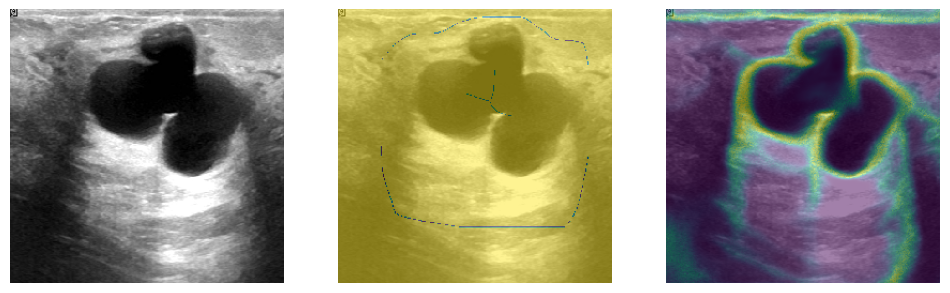

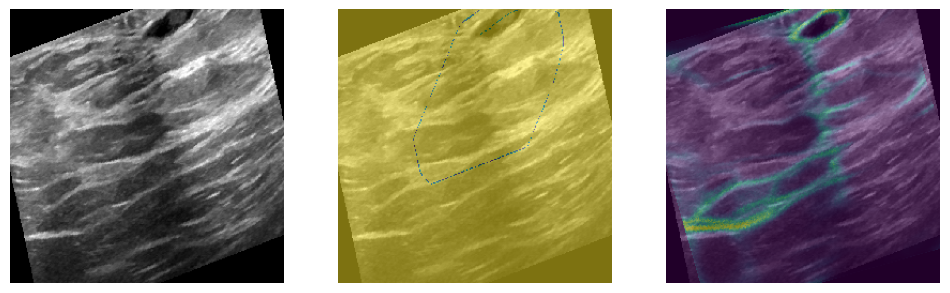

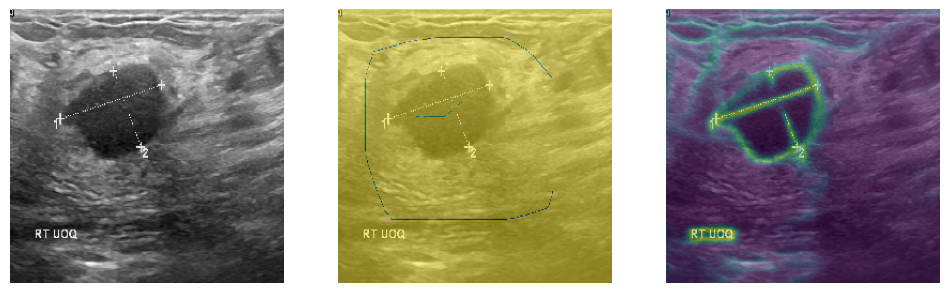

In [6]:
# Assuming train_set isacos already defined
num_samples = 3
num_cols = 3  # Number of columns for subplots

for i in range(num_samples):
    sample = train_set[i]
    image = sample['image']
    # gt = sample['gt']  # Uncomment if needed
    label = sample['label']
    edge = sample['edge_mask']
    
    plt.figure(figsize=(12, 8))

    # Subplot for the image
    plt.subplot(1, num_cols, 1)
    plt.imshow(image.squeeze(0), cmap='gray')
    plt.axis("off")
    
    # Subplot for the image with label
    plt.subplot(1, num_cols, 2)
    plt.imshow(image.squeeze(0), cmap='gray')
    plt.imshow(label, alpha=0.5)
    plt.axis("off")
    
    # Subplot for the image with edge mask
    plt.subplot(1, num_cols, 3)
    plt.imshow(image.squeeze(0), cmap='gray')
    plt.imshow(edge.squeeze(0), alpha=0.5)
    plt.axis("off")

    # Show the plots
    plt.show()